In [1]:
##########################################
#Step 0: Import libraries
##########################################
import os
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno

In [2]:
##########################################
#Step 1: Import data
##########################################

In [3]:
#Setting directory

os.chdir(r'C:\Users\jlenehan\OneDrive - Intel Corporation\Documents\0 - Data Science\Data Analytics Essentials\UCDPA_JohnLenehan\UCDPA_JohnLenehan')

In [4]:
#importing car crash data from chicago data portal
#url to overview page - https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if
collision_json = r'https://data.cityofchicago.org/resource/85ca-t3if.json?$limit=99999999' #json url

#using chunksize method to read in large datasets
collision_data = pd.read_json(collision_json) #reading collisions json

In [19]:
#importing beat data to join to main dataset
beat_data=pd.read_csv('PoliceBeatDec2012.csv')

print(beat_data.info())
print(beat_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   the_geom  277 non-null    object
 1   DISTRICT  277 non-null    int64 
 2   SECTOR    277 non-null    int64 
 3   BEAT      277 non-null    int64 
 4   BEAT_NUM  277 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 10.9+ KB
None
         DISTRICT      SECTOR        BEAT     BEAT_NUM
count  277.000000  277.000000  277.000000   277.000000
mean    12.122744    2.028881    2.028881  1235.241877
std      7.232131    0.924249    0.924249   722.945828
min      1.000000    0.000000    0.000000   111.000000
25%      6.000000    1.000000    1.000000   633.000000
50%     11.000000    2.000000    2.000000  1131.000000
75%     18.000000    3.000000    3.000000  1813.000000
max     31.000000    5.000000    5.000000  3100.000000


In [5]:
print(collision_data.head())

                                     crash_record_id               crash_date  \
0  193ecd8fa114a53b5fb84e4075d49eaa43bff79a3ed3c8...  2023-05-12T01:58:00.000   
1  5f51e1ee4da2e32fc7f176d163da7d4e8ab90bec958706...  2023-05-12T01:00:00.000   
2  81e65c18a5bc0396e19dec1bd287c09f47ad98f74ea306...  2023-05-12T00:46:00.000   
3  b35b9a9cc798edf61290e177bb3c498665cd842b1352a8...  2023-05-12T00:23:00.000   
4  b4799a0305e79f75fb2f42c45277c901e4745f23c4ef21...  2023-05-12T00:00:00.000   

   posted_speed_limit traffic_control_device      device_condition  \
0                  30            NO CONTROLS           NO CONTROLS   
1                  30         TRAFFIC SIGNAL  FUNCTIONING PROPERLY   
2                  30            NO CONTROLS           NO CONTROLS   
3                  30         TRAFFIC SIGNAL  FUNCTIONING PROPERLY   
4                  30            NO CONTROLS           NO CONTROLS   

  weather_condition      lighting_condition          first_crash_type  \
0             CLEAR

In [6]:
##########################################
#Step 2: Describe data
##########################################

In [7]:
#Describe recent incidents dataset
print(collision_data.columns)
print(collision_data.info())
print(collision_data.describe())
print(collision_data.shape)


Index(['crash_record_id', 'crash_date', 'posted_speed_limit',
       'traffic_control_device', 'device_condition', 'weather_condition',
       'lighting_condition', 'first_crash_type', 'trafficway_type',
       'alignment', 'roadway_surface_cond', 'road_defect', 'report_type',
       'crash_type', 'damage', 'date_police_notified',
       'prim_contributory_cause', 'sec_contributory_cause', 'street_no',
       'street_direction', 'street_name', 'beat_of_occurrence', 'num_units',
       'most_severe_injury', 'injuries_total', 'injuries_fatal',
       'injuries_incapacitating', 'injuries_non_incapacitating',
       'injuries_reported_not_evident', 'injuries_no_indication',
       'injuries_unknown', 'crash_hour', 'crash_day_of_week', 'crash_month',
       'latitude', 'longitude', 'location', 'intersection_related_i',
       'hit_and_run_i', 'photos_taken_i', 'crash_date_est_i',
       'private_property_i', 'statements_taken_i', 'dooring_i', 'work_zone_i',
       'work_zone_type', 'workers

In [8]:
#converting location data to string
collision_data['location']=collision_data['location'].astype(str)

print('\nSFPD Historical Incidents - Unique Values:')
for x in collision_data.columns:
    print(x+':')
    print(collision_data[x].unique())
    print(str(collision_data[x].nunique()) + str(' unique values'))


SFPD Historical Incidents - Unique Values:
crash_record_id:
['193ecd8fa114a53b5fb84e4075d49eaa43bff79a3ed3c863069b92b542ee92e190cd95c39270d1286985d4dcf9afd1956f67d15fee2725dfc2ea51523c5990d8'
 '5f51e1ee4da2e32fc7f176d163da7d4e8ab90bec958706c95b05e5d77476d37994ee56b0fd527f955520237a34815ef0f50d3905df91c5cff7e629e2055f2ecc'
 '81e65c18a5bc0396e19dec1bd287c09f47ad98f74ea3065f3f84a77d9921d927be2bff35eb7cdeed317b0391d6266a0ff82b9afdf9ebf00617403bd08db33340'
 ...
 'f62e27317feb174811cf4fefeb9fa1064fea6c0619a8738e23545309256850d853008824fcf0ac07a71ef076b34be514e532e10d4a441c72c619b63e6193d72a'
 '19fb5af681f833c2af85734245f737fa6fbe62ac1ea379e14e22f71138add54f31f27960167f0ea70e7575704c5c7beb9a110fa7481f50b395c510814752a834'
 'a802658be15312809c771559e4f81088cfb226830792a50470f4ecf9dbdc4fd83c1e187199279ea53e604a6cc30bc0c0fd5ba00b0c0e924746c0f4a23b44edc5']
721213 unique values
crash_date:
['2023-05-12T01:58:00.000' '2023-05-12T01:00:00.000'
 '2023-05-12T00:46:00.000' ... '2014-01-18T18:14:00.000

['NO INDICATION OF INJURY' 'NONINCAPACITATING INJURY'
 'REPORTED, NOT EVIDENT' nan 'INCAPACITATING INJURY' 'FATAL']
5 unique values
injuries_total:
[ 0.  1.  4.  2. nan  3.  9.  5.  7. 15.  6.  8. 11. 12. 10. 17. 21. 19.
 13. 16.]
19 unique values
injuries_fatal:
[ 0. nan  1.  2.  3.  4.]
5 unique values
injuries_incapacitating:
[ 0. nan  1.  2.  3.  5.  4.  6.  7.]
8 unique values
injuries_non_incapacitating:
[ 0.  1.  4.  2. nan  3.  9. 15.  6.  5.  7. 12.  8. 10. 19. 14. 18. 16.
 11. 21.]
19 unique values
injuries_reported_not_evident:
[ 0.  1.  2. nan  4.  3.  7.  5.  6.  9. 10.  8. 11. 15.]
13 unique values
injuries_no_indication:
[ 2.  0.  3.  1.  5.  8.  4. nan  6.  7. 11. 15.  9. 13. 10. 45. 19. 16.
 33. 23. 12. 37. 22. 29. 14. 20. 17. 21. 26. 28. 24. 32. 30. 42. 31. 36.
 50. 18. 40. 27. 46. 34. 61. 25. 39. 38.]
45 unique values
injuries_unknown:
[ 0. nan]
1 unique values
crash_hour:
[ 1  0 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4  2  3]
24 unique values
cras

In [9]:
##########################################
#Step 3: Clean + Manipulate data
##########################################

In [10]:
#Converting Incident datetime, Report Datetime to a datetime object
#sfpd_incident_current[['incident_datetime','report_datetime']] = sfpd_incident_current[['incident_datetime','report_datetime']].apply(pd.to_datetime)

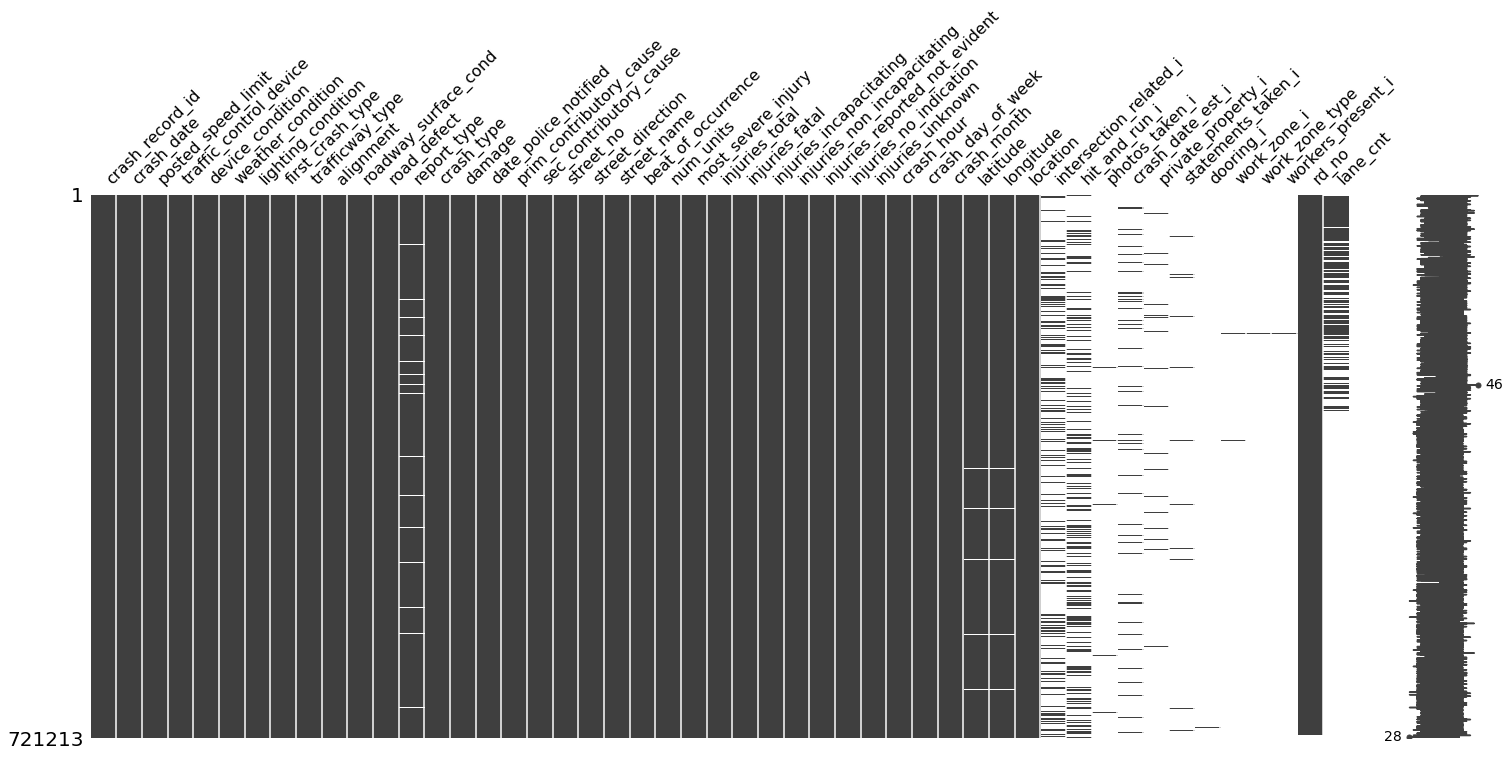

<class 'pandas.core.frame.DataFrame'>
Int64Index: 721213 entries, 721212 to 0
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   crash_record_id                721213 non-null  object 
 1   crash_date                     721213 non-null  object 
 2   posted_speed_limit             721213 non-null  int64  
 3   traffic_control_device         721213 non-null  object 
 4   device_condition               721213 non-null  object 
 5   weather_condition              721213 non-null  object 
 6   lighting_condition             721213 non-null  object 
 7   first_crash_type               721213 non-null  object 
 8   trafficway_type                721213 non-null  object 
 9   alignment                      721213 non-null  object 
 10  roadway_surface_cond           721213 non-null  object 
 11  road_defect                    721213 non-null  object 
 12  report_type                   

In [11]:
#Visualising missing data

#Sorting values by report received date
collision_data = collision_data.sort_values(by='crash_date',ascending=True)

#plotting matrix of missing data
msno.matrix(collision_data)
plt.show()

#info of sorted data
print(collision_data.info())

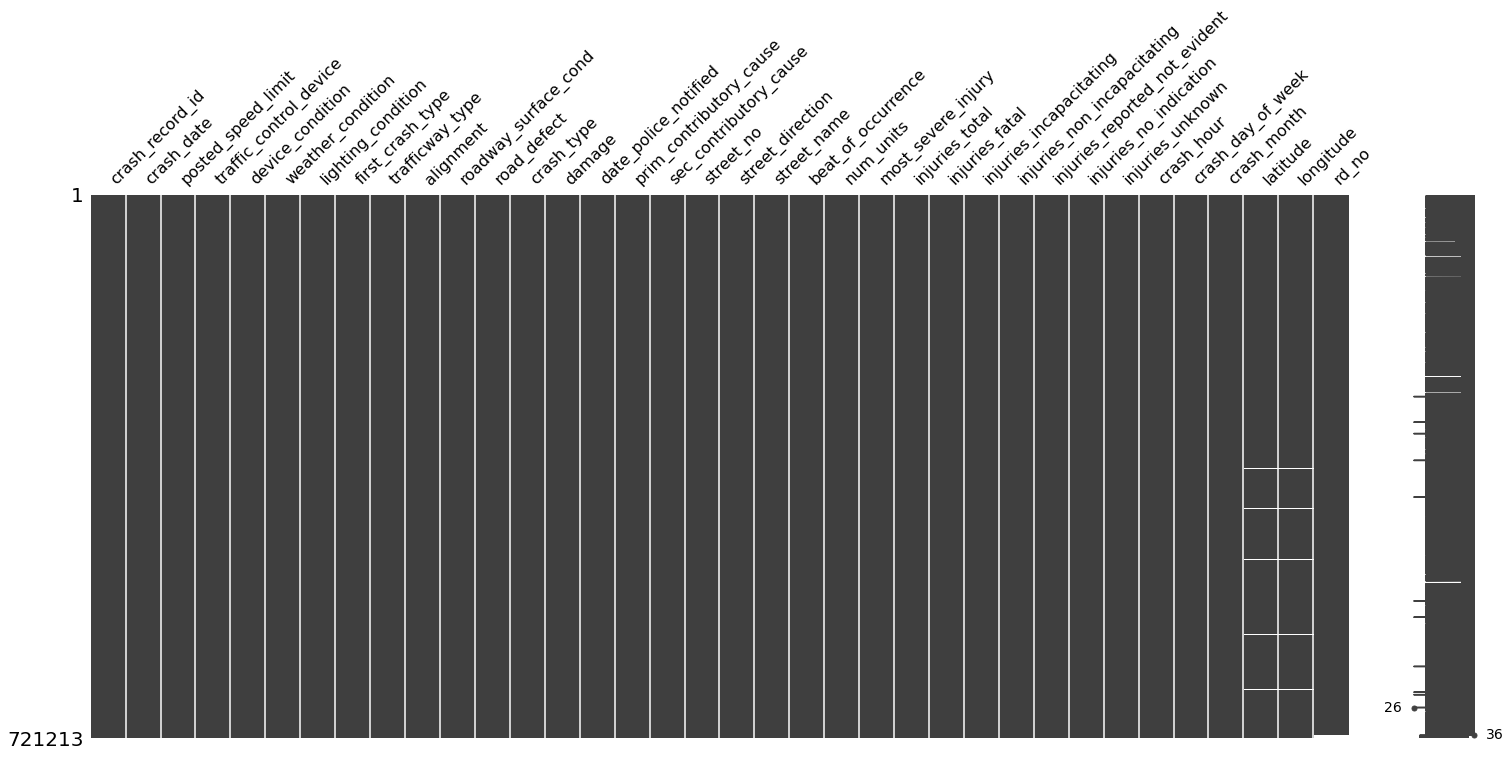

<class 'pandas.core.frame.DataFrame'>
Int64Index: 721213 entries, 721212 to 0
Data columns (total 36 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   crash_record_id                721213 non-null  object 
 1   crash_date                     721213 non-null  object 
 2   posted_speed_limit             721213 non-null  int64  
 3   traffic_control_device         721213 non-null  object 
 4   device_condition               721213 non-null  object 
 5   weather_condition              721213 non-null  object 
 6   lighting_condition             721213 non-null  object 
 7   first_crash_type               721213 non-null  object 
 8   trafficway_type                721213 non-null  object 
 9   alignment                      721213 non-null  object 
 10  roadway_surface_cond           721213 non-null  object 
 11  road_defect                    721213 non-null  object 
 12  crash_type                    

In [12]:
#dropping unnecessary columns
drop_cols = ['location', 'report_type', 'intersection_related_i',
       'hit_and_run_i', 'photos_taken_i', 'crash_date_est_i', 'beat_of_occurence',
       'private_property_i', 'statements_taken_i', 'dooring_i', 'work_zone_i',
       'work_zone_type', 'workers_present_i','lane_cnt'
            ]

collision_data=collision_data.drop(columns=drop_cols)

#plotting matrix of missing data
msno.matrix(collision_data)
plt.show()

#info of sorted data
print(collision_data.info())

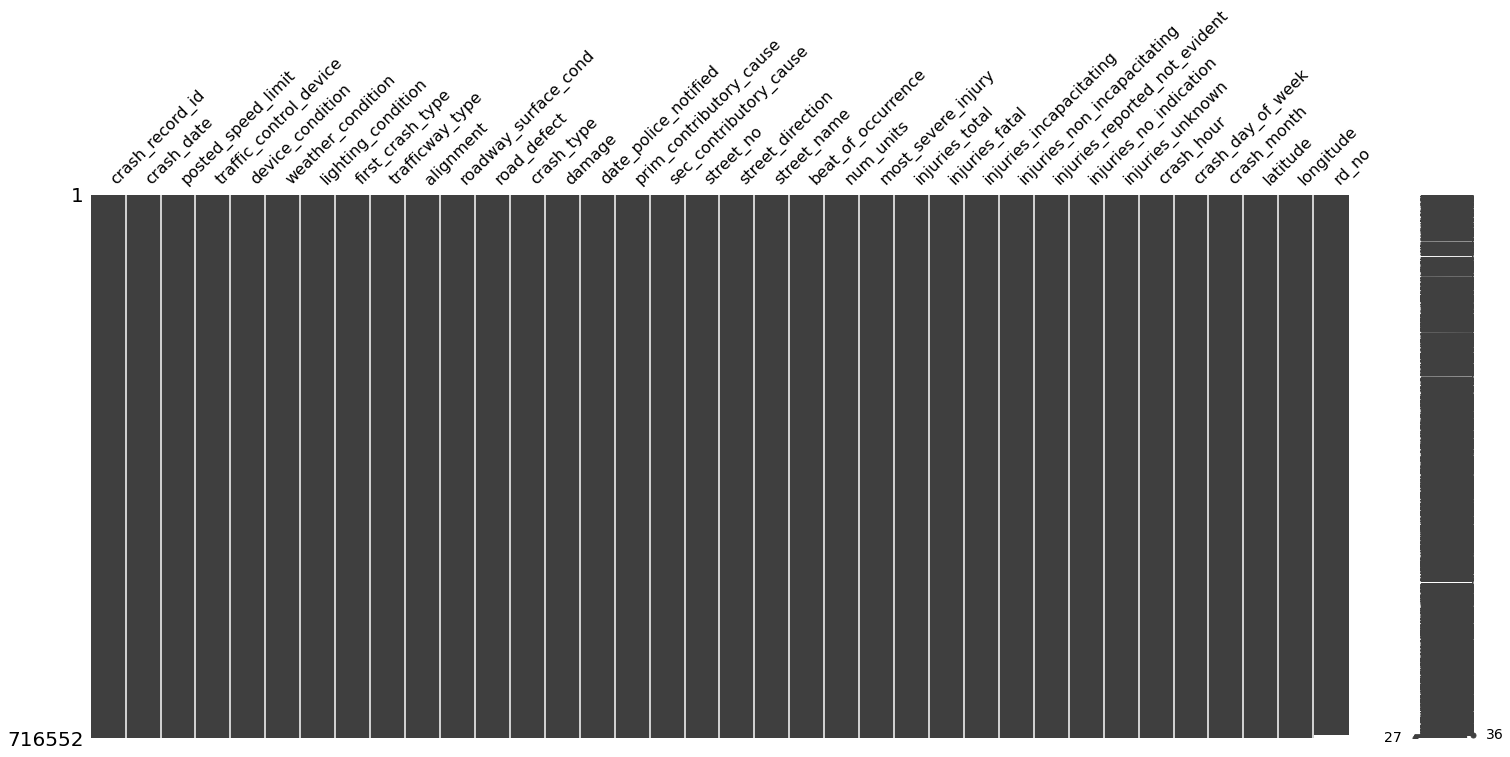

<class 'pandas.core.frame.DataFrame'>
Int64Index: 716552 entries, 721212 to 0
Data columns (total 36 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   crash_record_id                716552 non-null  object 
 1   crash_date                     716552 non-null  object 
 2   posted_speed_limit             716552 non-null  int64  
 3   traffic_control_device         716552 non-null  object 
 4   device_condition               716552 non-null  object 
 5   weather_condition              716552 non-null  object 
 6   lighting_condition             716552 non-null  object 
 7   first_crash_type               716552 non-null  object 
 8   trafficway_type                716552 non-null  object 
 9   alignment                      716552 non-null  object 
 10  roadway_surface_cond           716552 non-null  object 
 11  road_defect                    716552 non-null  object 
 12  crash_type                    

In [13]:
#exclude rows missing geolocation data
collision_data = collision_data.dropna(subset = ['latitude'])

#plotting matrix of data
msno.matrix(collision_data)
plt.show()

#data info
print(collision_data.info())


In [14]:
##########################################
#Step 4: Joining data
##########################################

In [15]:
##########################################
#Step 5: Plot data
##########################################

In [16]:
##########################################
#Step 6: Machine Learning
##########################################